Boiler plate code to ensure files in the drive are automatically re-loaded

In [1]:
%load_ext autoreload
%autoreload 2

Connect to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive Path to connect to google drive, edit drive path to the one used by the user currently. Only the variable GOOGLE_DRIVE_PATH_AFTER_MYDRIVE needs to be modified.

In [3]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Predictive_Maintenance_Bearings'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', '.ipynb_checkpoints', 'Back', 'preprocessing', 'data', 'plot3d.xlsx', 'Models', 'Results', 'Source_domain.pth', 'transfer_learning.py', 'cnn_architecture.py', 'Source_domain_FE.pth', 'Inference.ipynb', 'Target_Network.ipynb', 'optimize.py', 'Source_domain_FE_norm.pth', 'Source_Network.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import time
import math
import pandas as pd
import numpy as np
%matplotlib inline

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings')

Good to go!


In [7]:
from torchvision.models.vgg import vgg16
import torchvision.models as models
from torchvision import datasets, transforms

data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data/CWRU/New_Data/FE12k/')
os.listdir(data_dir)
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x))
#                   for x in ['training', 'validation', 'test']}

['Val', 'Train', 'Test']

In [8]:
import multiprocessing

torch.manual_seed(0)

data_transforms = {
    'Test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.2496, 0.2000, 0.4676], [0.4328, 0.4000, 0.4989])
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load data from disk

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

# data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'Data/Source_Dataset/')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Test']}


In [9]:
# Test Dataloader
test_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Test'], batch_size = BATCH_SIZE, 
                                              num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)

test_loader_iter = iter(test_dataloader)
image, batches = next(test_loader_iter)
dataset_sizes = {x: len(image_datasets[x]) for x in ['Test']}
path_classes_train = {x: len(os.listdir(os.path.join(data_dir, 'Train/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_val = {x: len(os.listdir(os.path.join(data_dir, 'Val/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_test = {x: len(os.listdir(os.path.join(data_dir, 'Test/'+ x))) for x in ['Faulty', 'Healthy']}
class_names = image_datasets['Test'].classes

B, C, H, W = image.shape[0], image.shape[1], image.shape[2], image.shape[3]

print(f"path classes:                 {path_classes_train}" )
print(f"path classes:                 {path_classes_val}")
print(f"path classes:                 {path_classes_test}")
print(f"image has shape (B, C, H, W): {image.shape}")
print(f"image batch has shape       : {batches.shape}")
print(f"dataset_sizes               : {dataset_sizes}")
print(f"Class names                 : {class_names}")

path classes:                 {'Faulty': 2787, 'Healthy': 2787}
path classes:                 {'Faulty': 700, 'Healthy': 700}
path classes:                 {'Faulty': 875, 'Healthy': 875}
image has shape (B, C, H, W): torch.Size([4, 3, 224, 224])
image batch has shape       : torch.Size([4])
dataset_sizes               : {'Test': 1750}
Class names                 : ['Faulty', 'Healthy']


In [10]:
from cnn_architecture import CNN_Architecture

torch.manual_seed(0)

DEVICE = torch.device("cuda")
# Path to model parameters
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Source_domain_FE_norm.pth')
test_model = CNN_Architecture(input_dims=(C, H, W), num_classes=2,
                              dtype=torch.float32, device=DEVICE)

test_model = test_model.to(DEVICE)
# Load the model
checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
for params in test_model.classify[6].parameters():
  print(params)

Parameter containing:
tensor([[ 0.1684, -0.1469, -0.0500, -0.0969, -0.0226, -0.0033, -0.1524, -0.0290,
          0.0885, -0.1035,  0.0081,  0.2944,  0.0628,  0.0588, -0.0067,  0.0791,
          0.0677,  0.1621,  0.2293,  0.0673,  0.1065,  0.3792, -0.2006,  0.0445,
          0.0567,  0.1759,  0.1578,  0.1825, -0.0258,  0.0096,  0.0866, -0.0144,
          0.1467,  0.2423,  0.0471, -0.0573,  0.2423, -0.1403,  0.0334, -0.3068,
         -0.0322,  0.0038,  0.2465, -0.0269, -0.0409,  0.0071, -0.0140,  0.1071,
          0.1096, -0.0039,  0.1358, -0.0518, -0.0225, -0.1494, -0.0368,  0.2479,
         -0.2476,  0.0963,  0.1512,  0.0311, -0.1172, -0.0100,  0.1064, -0.1935,
          0.0764,  0.0292,  0.0798, -0.0606, -0.1079, -0.1064, -0.0643,  0.0836,
         -0.0429, -0.1352, -0.0311, -0.2174, -0.0791,  0.0211,  0.1732, -0.0073,
         -0.1338, -0.0139,  0.0140, -0.1588,  0.1565, -0.0469,  0.0770, -0.1625,
         -0.1398,  0.0023,  0.0275, -0.0569, -0.0758, -0.0201, -0.0898, -0.0615,
      

GroundTruth:  Faulty Faulty Faulty Faulty
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


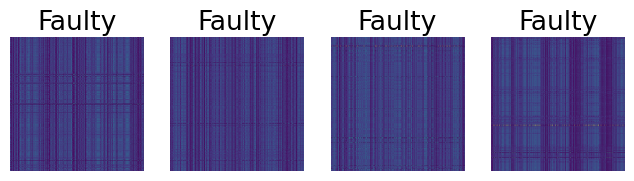

In [23]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

classes = ['Faulty', 'Healthy']
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

mean = torch.tensor([0.2496, 0.2000, 0.4676])
std = torch.tensor([0.4328, 0.4000, 0.4989])
for i in range(images.shape[0]):
  im = images[i, :, :, :]
  im = im*std.view(3,1,1) + mean.view(3,1,1)
  plt.subplot(2, 5, i+1).set_title(f'{classes[labels[i]]}')
  plt.imshow(torch.permute(im, (1,2,0)))
  plt.axis('off')

In [24]:
torch.manual_seed(0)

test_model.eval()
images = images.to(DEVICE)
outputs = test_model(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(len(images))))

Predicted:  Faulty Faulty Faulty Faulty


In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
torch.manual_seed(0)

with torch.no_grad():
  for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = test_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network with test images of: {100 * correct / total} %')

Accuracy of the network with test images of: 99.94285714285714 %


Accuracy of Network Achieved with DE12k with no normalization- 100.0% <br>
Accuracy of the network with FE12k with no normalization - 100.0% <br>
Accuracy of Network with FE12k with normalization - 99.943% <br>